Assignment 5 <br>
Ken Lopez <br>
Aiman Madan <br>

https://colab.research.google.com/drive/1cBEcJrPWzLzfmDsZ6o-QeuLlp0u9rmoH?usp=sharing


# Binary vs Multi-Class Classification

In binary classification, there are only to classes, targets, or features. In a multi-class classification problem there are three or more distinct classes. In a multi-class model, the model would need to categorize the data into an instance of one of the varies classes. In contrast, a binary model's task would be to accurately distinguish between two possible outcomes, in this case it would be label the data point into one of two classes, 'oscillation' or 'normal'.

Our model will be able to differentiate between the two classes in this binary classification problem

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from google.colab import files
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
uploaded = files.upload()


Saving test.csv to test.csv
Saving training.csv to training.csv


In [ ]:
training_data = pd.read_csv('training.csv', header=None, usecols=[19,23], names=['Time','Current'])
test_data = pd.read_csv('test.csv', header=None, usecols=[0, 4], names=['Time','Current'])


In [ ]:
training_data

,Time,Current
0,0.00000,-0.807514
1,0.00005,-0.806968
2,0.00010,-0.806291
3,0.00015,-0.804651
4,0.00020,-0.801798
...,...,...
299996,14.99980,-0.979724
299997,14.99985,-0.954137
299998,14.99990,-0.927560
299999,14.99995,-0.900309


In [ ]:
test_data

,Time,Current
0,0.00000,-0.807514
1,0.00005,-0.806968
2,0.00010,-0.806291
3,0.00015,-0.804651
4,0.00020,-0.801798
...,...,...
119996,5.99980,-0.596946
119997,5.99985,-0.579137
119998,5.99990,-0.556793
119999,5.99995,-0.528649


In [ ]:
training_data = training_data[training_data['Time'] <= 5.4]
test_data = test_data[test_data['Time'] <= 2.4]

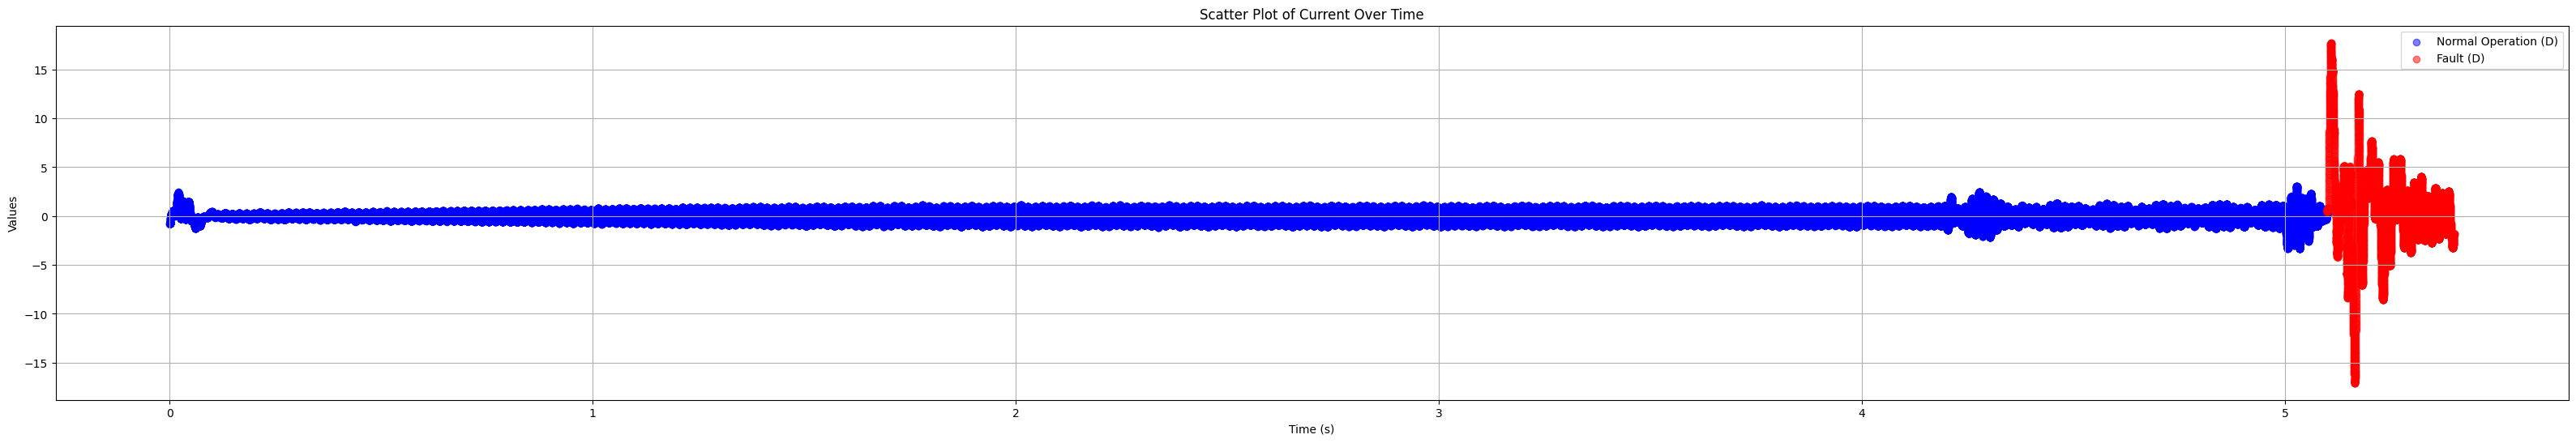

In [ ]:
import matplotlib.pyplot as plt

df = training_data
fault_start = 5.1
fault_end = 5.4
# Separate the data points
fault_data = df[(df['Time'] >= fault_start) & (df['Time'] <= fault_end)]
normal_data = df[(df['Time'] < fault_start) | (df['Time'] > fault_end)]

plt.figure(figsize=(40, 6))

# Plotting for column D
plt.scatter(normal_data['Time'], normal_data['Current'], c='blue', label='Normal Operation (D)', alpha=0.5)
plt.scatter(fault_data['Time'], fault_data['Current'], c='red', label='Fault (D)', alpha=0.5)


plt.title('Scatter Plot of Current Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

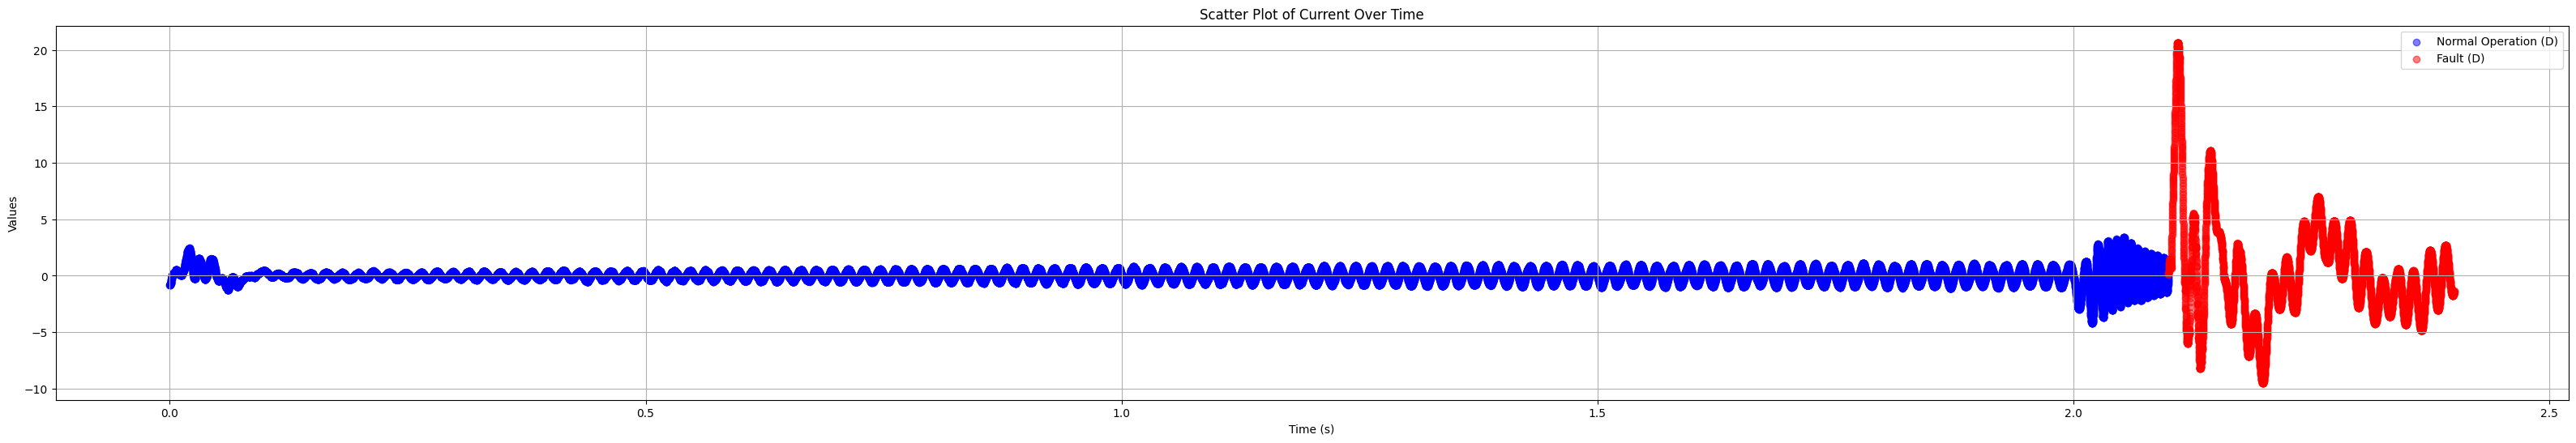

In [ ]:
import matplotlib.pyplot as plt

df = test_data
fault_start = 2.1
fault_end = 2.4
# Separate the data points
fault_data = df[(df['Time'] >= fault_start) & (df['Time'] <= fault_end)]
normal_data = df[(df['Time'] < fault_start) | (df['Time'] > fault_end)]

plt.figure(figsize=(40, 6))

# Plotting for column D
plt.scatter(normal_data['Time'], normal_data['Current'], c='blue', label='Normal Operation (D)', alpha=0.5)
plt.scatter(fault_data['Time'], fault_data['Current'], c='red', label='Fault (D)', alpha=0.5)


plt.title('Scatter Plot of Current Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define segmenting and labeling function

def segment_labeling(data, window, overlap, time1, time2):

  # Define the number of data points per segment = window size

  #index determines the start of a window
  #in each step of segmenting loop
  index = 0

  #windolap incorporates overlaping percentage
  windolap = math.floor (window * overlap)

  # Create an empty DataFrame for storing the labels
  labels_df = pd.DataFrame(columns=['label'])

  time_series = []

  while (index + window) < len(data):
      # Extract a segment of data
      segment = data.iloc[index : (index+window)]

      # Labeling based on a given time (the oscillation time is given)
      if any((time1 <= t <= time2) for t in segment['Time']):
        label = 'oscillation'
      else:
        label = 'normal'

      time_series.append(segment['Current'])

      # Append the label to the labels DataFrame
      labels_df = pd.concat([labels_df, pd.DataFrame({'label': [label]})], ignore_index=True)

      #Shifting the index forward by stride = window - windolap
      index += window - windolap

  # return lables_df as a DataFrame
  return time_series, labels_df

In [ ]:
window = 200
overlap = 0.75

train_X, train_y = segment_labeling(training_data, window, overlap, 5.1, 5.4)
test_X, test_y = segment_labeling(test_data, window, overlap, 2.1, 2.4)

In [ ]:
train_y.value_counts()

,count
label,
normal,2037
oscillation,120


In [ ]:
test_y.value_counts()

,count
label,
normal,837
oscillation,120


In [ ]:
X_train = np.array(train_X)
X_test = np.array(test_X)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(2157, 200)
(957, 200)


# Choosing Decision Tree

In this binary classification problem, we choose a decision tree approach because the model could be easily visualized and easily interpreted. We are able to see the the decisions made by the model that helps it distinguish between the two classes. We are able to understand the features that contribute to identifying most of the faults or oscillations, which provide more insight and help us tune the model with key aspects.

The relationship between normal and oscillation is not linear, the state depend on crossing specific thresholds, in this problem it is checking whether a the current time segment falls within the oscillation interval, and decision tree are well suited to identify where certain ranges could strongly indicate a fault.

In [ ]:
# Train the Decision Tree on the raw segments
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, train_y['label'].apply(lambda x: 1 if x == 'oscillation' else 0))
y_pred = clf.predict(X_test)


# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(test_y['label'].apply(lambda x: 1 if x == 'oscillation' else 0), y_pred))
print("\nClassification Report:")
print(classification_report(test_y['label'].apply(lambda x: 1 if x == 'oscillation' else 0), y_pred))


Confusion Matrix:
[[826  11]
 [ 31  89]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       837
           1       0.89      0.74      0.81       120

    accuracy                           0.96       957
   macro avg       0.93      0.86      0.89       957
weighted avg       0.95      0.96      0.95       957



# Tuning Hyperparameters, Store Best Parameters

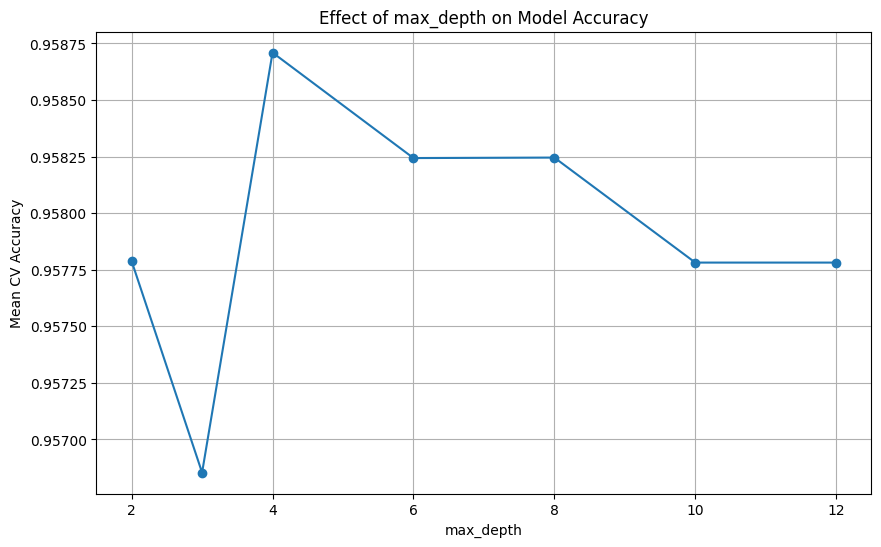

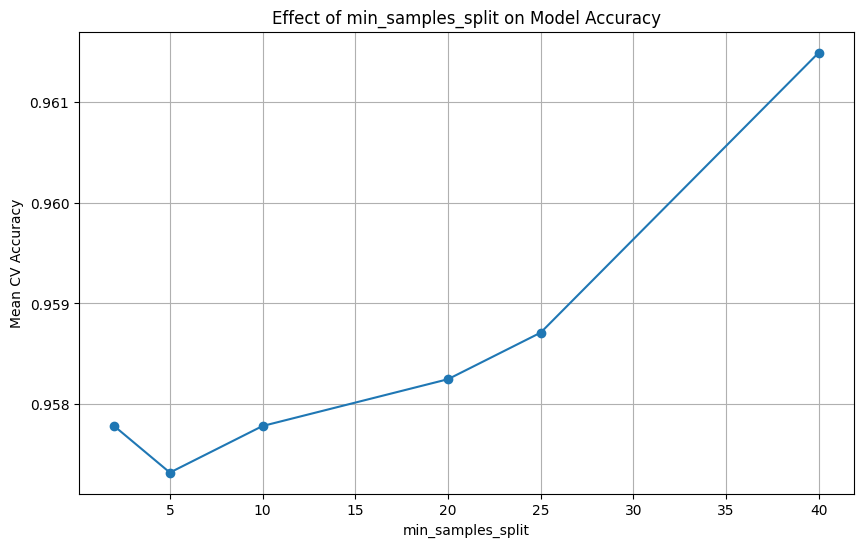

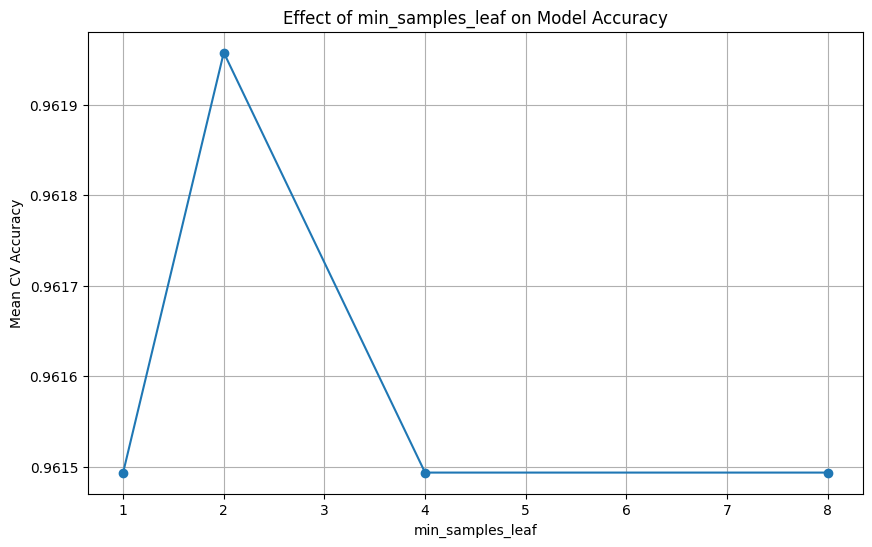

Best Parameters: {'max_depth': 4, 'min_samples_split': 40, 'min_samples_leaf': 2}

Confusion Matrix:
[[821  16]
 [ 27  93]]

Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.98      0.97       837
 oscillation       0.85      0.78      0.81       120

    accuracy                           0.96       957
   macro avg       0.91      0.88      0.89       957
weighted avg       0.95      0.96      0.95       957



In [ ]:
clf = DecisionTreeClassifier(random_state=42)

# Dictionary to store the best parameters
best_params = {}

# Modified function to store the best parameter
def plot_hyperparameter_tuning(param_name, param_range, xlabel):
    mean_scores = []
    best_score = 0
    best_param_value = None

    for param_value in param_range:
        # Set the parameter
        clf.set_params(**{param_name: param_value})
        # Perform cross-validation and store the mean accuracy
        scores = cross_val_score(clf, X_train, train_y, cv=5, scoring='accuracy')
        mean_accuracy = scores.mean()
        mean_scores.append(mean_accuracy)

        # Update the best score and parameter value
        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_param_value = param_value

    # Save the best parameter for this hyperparameter
    best_params[param_name] = best_param_value

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, mean_scores, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel('Mean CV Accuracy')
    plt.title(f'Effect of {xlabel} on Model Accuracy')
    plt.grid(True)
    plt.show()

# Tune max_depth
plot_hyperparameter_tuning('max_depth', param_range=[2, 3, 4, 6, 8, 10, 12], xlabel='max_depth')

# Tune min_samples_split
plot_hyperparameter_tuning('min_samples_split', param_range=[2, 5, 10, 20, 25, 40], xlabel='min_samples_split')

# Tune min_samples_leaf
plot_hyperparameter_tuning('min_samples_leaf', param_range=[1, 2, 4, 8], xlabel='min_samples_leaf')

# Print the best parameters
print("Best Parameters:", best_params)

# Create a new Decision Tree using the best parameters
optimized_clf = DecisionTreeClassifier(**best_params, random_state=42)
optimized_clf.fit(X_train, train_y)

# Evaluate the model
y_pred = optimized_clf.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))
print("\nClassification Report:")
print(classification_report(test_y, y_pred))


# Training with Cross Validation

In [ ]:
#set best parameters from tuning
best_params = {
    'max_depth': 4,
    'min_samples_split': 40,
    'min_samples_leaf': 2
}

# Initialize the Decision Tree with the specified parameters
optimized_clf = DecisionTreeClassifier(**best_params, random_state=42)

# Perform cross-validation to evaluate the model with the best parameters
cv_scores = cross_val_score(optimized_clf, X_train, train_y, cv=5, scoring='accuracy')

# Display the cross-validation scores and the mean accuracy
print("Cross-Validation Scores with Specified Parameters:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

# Train the final model on the entire training set using the specified parameters
optimized_clf.fit(X_train, train_y)

# Evaluate the model on the test set
y_pred = optimized_clf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))

print("\nClassification Report:")
print(classification_report(test_y, y_pred))


Cross-Validation Scores with Specified Parameters: [0.98148148 1.         0.99767981 0.98839907 0.83990719]
Mean Cross-Validation Accuracy: 0.9614935120735584

Confusion Matrix:
[[821  16]
 [ 27  93]]

Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.98      0.97       837
 oscillation       0.85      0.78      0.81       120

    accuracy                           0.96       957
   macro avg       0.91      0.88      0.89       957
weighted avg       0.95      0.96      0.95       957

